In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
import pprint
from datetime import timedelta
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error



In [ ]:
# load and display data

df = pd.read_csv('./data/baci_monthly.csv')
print(f"Total samples: {len(df)}")
print(df.head())

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)



df['Diff'] = df['CLOSE'].diff()
df["CLOSE"].plot(kind='line', title='Monthly BACI')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

df["Diff"].plot(kind="line", title="Monthly BDI Difference")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


In [ ]:
# correlograms to assess lags

# first difference
plot_acf(df['Diff'].dropna(), lags=40, title="ACF BACI Difference")
plot_pacf(df['Diff'].dropna(), lags=40, title="PACF BACI Difference")

# actual values
plot_acf(df["CLOSE"], lags=40, title="ACF BACI")
plot_pacf(df["CLOSE"], lags=40, title="PACF BACI")
plt.show()

In [ ]:
# STATIONARITY TESTS

# augmented dickey fuller

values = df["CLOSE"]

result = adfuller(values.dropna())
print('p-value: ', result[1])

result = adfuller(values.diff().dropna())
print('p-value: ', result[1])

result = adfuller(values.diff().diff().dropna())
print('p-value: ', result[1])

# Phillips-Perron

pp_test = PhillipsPerron(values.dropna())
print(pp_test.summary())


pp_test = PhillipsPerron(values.diff().dropna())
print(pp_test.summary())

# KPSS test
statistic, p_value, n_lags, critical_values = kpss(values, regression='c')

print(f"KPSS Statistic: {statistic}")
print(f"P-value: {p_value}")
print(f"Num Lags: {n_lags}")
print("Critical Values:", critical_values)

if p_value < 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

statistic, p_value, n_lags, critical_values = kpss(values.diff().dropna(), regression='c')

print(f"KPSS Statistic: {statistic}")
print(f"P-value: {p_value}")
print(f"Num Lags: {n_lags}")
print("Critical Values:", critical_values)

if p_value < 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")


In [ ]:
# Fit the ARIMA model
"""
train_size = int(0.8 * len(df))
train = values.iloc[:train_size]
test = values.iloc[train_size:]
arima_model = ARIMA(train.dropna(), order=(3,1,3))
model = arima_model.fit()
fitted_values = model.fittedvalues


print(model.summary())
"""



C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


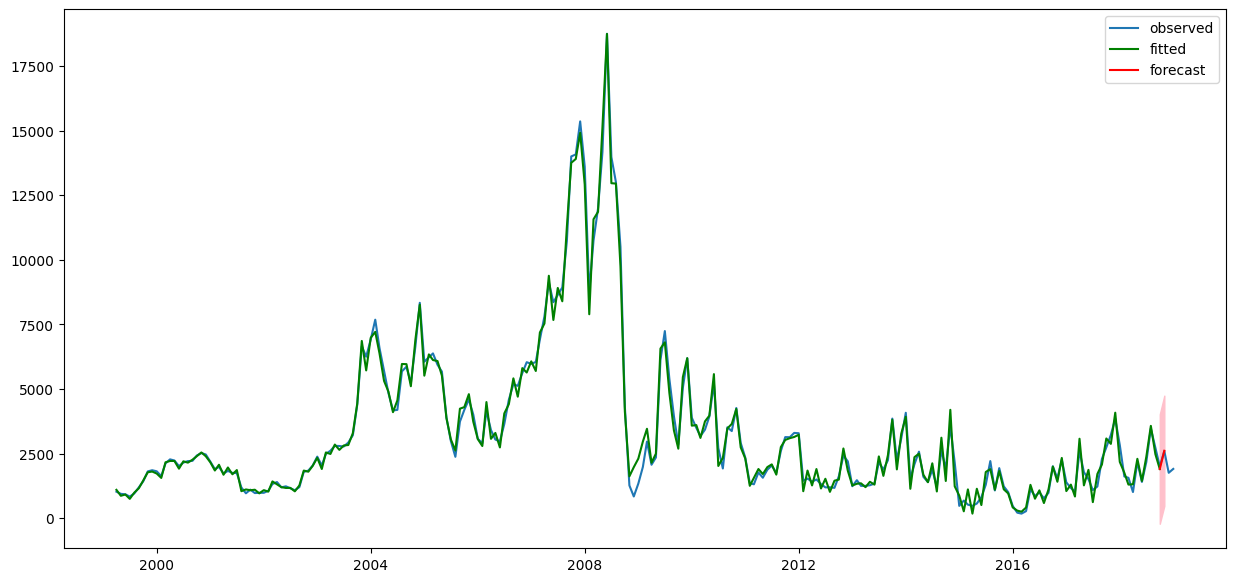

C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


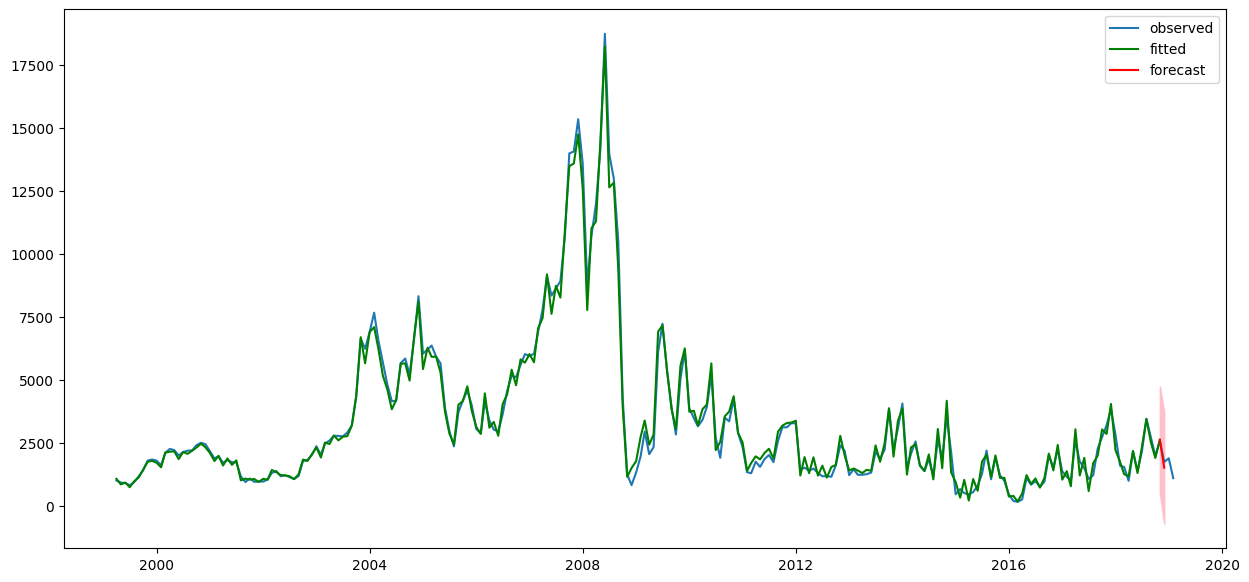

C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


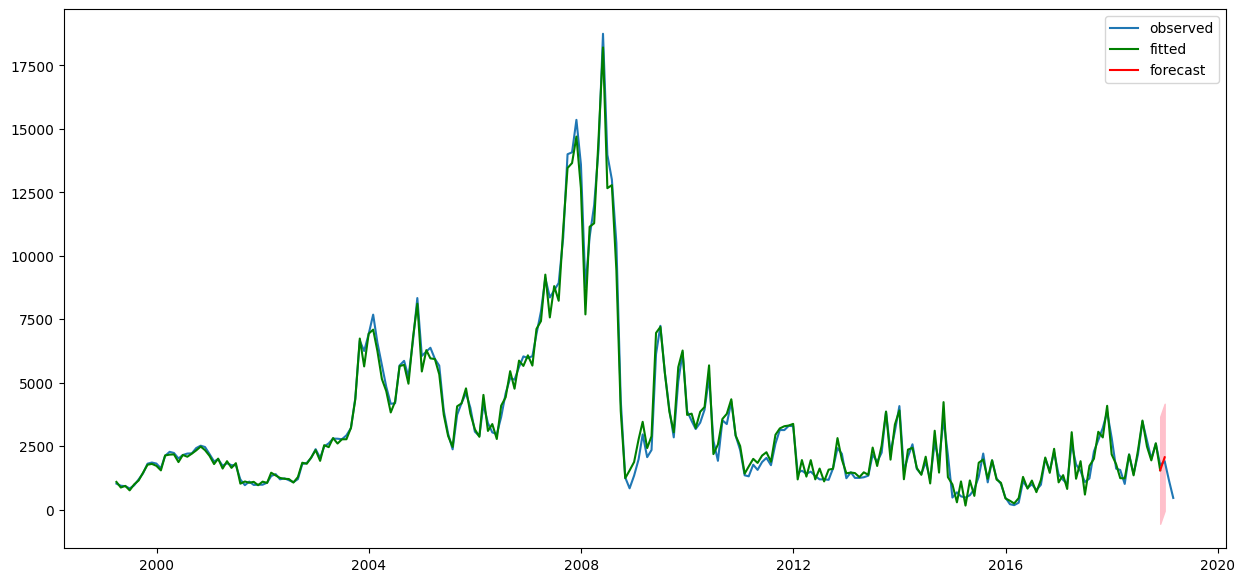

C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


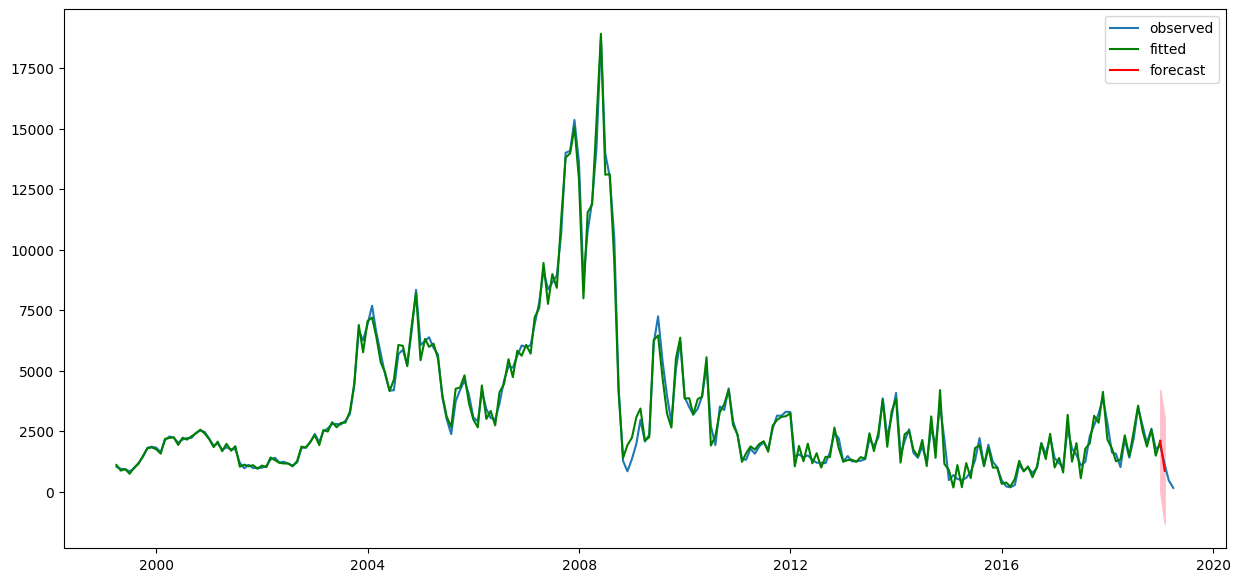

C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


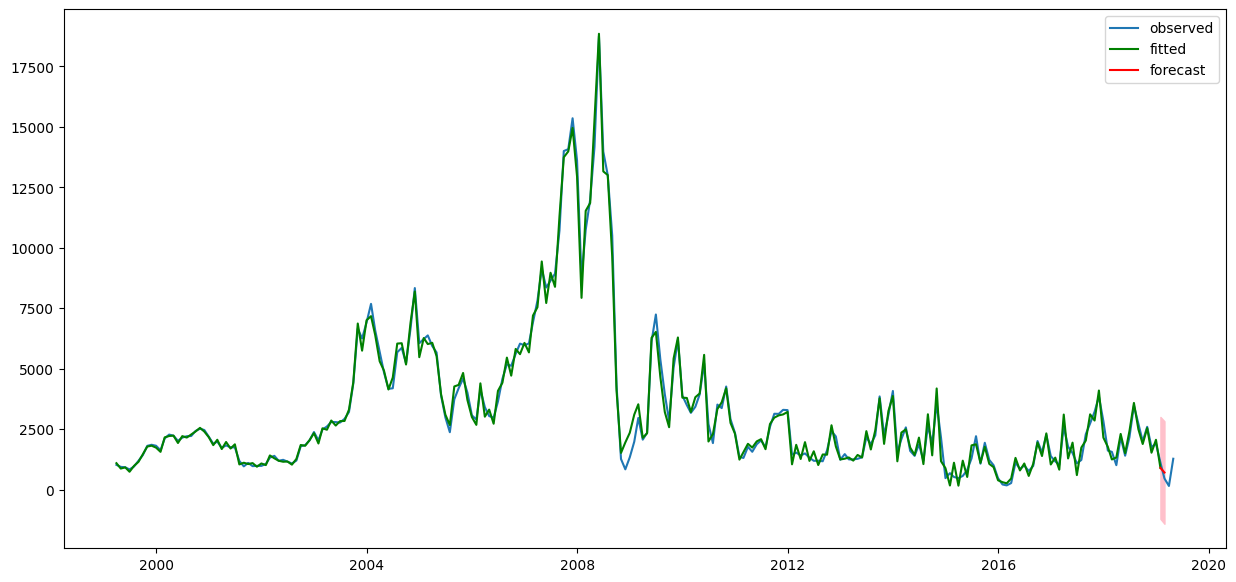

[852.686276437068, 375.09888879137, 944.4874498956701, 396.5669190132779, 556.1480239378516]


In [7]:

def ARIMA_forecasts(data: pd.DataFrame,
                   months_ahead: int=1, 
                   train_ratio: float=0.8,
                   p: int=3, 
                   i: int=1, 
                   q: int=3,
                   n_forecasts: int=1,
                   plot: bool=True):
    
    def plot_forecast():
            true_values = data["CLOSE"]
            fitted_values = model.fittedvalues.shift(-1).dropna()
            # Append the last fitted value to the forecasted values
            forecast_values = np.insert(mean_forecast.values, 0, fitted_values.values[-1])
            forecast_dates = pd.date_range(start=fitted_values.index[-1], periods=len(forecast_values), freq='M')

            # Plot
            # Get standard error from the model fit
            std_error = np.std(model.resid)

            # Plot
            plt.figure(figsize=(15,7))
            plt.plot(true_values.iloc[:train_size + months_ahead].index, true_values.iloc[:train_size + months_ahead].values, label='observed')
            plt.plot(fitted_values.index, fitted_values.values, color='green', label='fitted')

            # Combined forecast values including the last fitted value
            forecast_values = np.insert(mean_forecast.values, 0, fitted_values.values[-1])
            forecast_dates = pd.date_range(start=fitted_values.index[-1], periods=len(forecast_values), freq='M')
            plt.plot(forecast_dates, forecast_values, color='red', label='forecast')

            if conf_int is not None:
                # Create confidence intervals for the last fitted value
                conf_int_last_fitted = [
                    fitted_values.values[-1] - 1.96 * std_error,  # lower bound
                    fitted_values.values[-1] + 1.96 * std_error   # upper bound
                ]

                # Append these intervals to the forecasted confidence intervals
                conf_int_values = np.vstack((
                    conf_int_last_fitted,
                    conf_int.values
                ))

                # Fill between for combined confidence intervals
                plt.fill_between(forecast_dates, conf_int_values[:, 0], conf_int_values[:, 1], color='pink')

            plt.legend()
            plt.show()

    forecast_wrappers = []
    
    train_size = int(train_ratio * len(data))
    for _ in range(n_forecasts):
        train = data["CLOSE"].iloc[:train_size]
        test = data["CLOSE"].iloc[train_size:train_size + months_ahead]

        arima_model = ARIMA(train.dropna(), order=(p, i, q))
        model = arima_model.fit()

        forecast = model.get_forecast(steps=months_ahead)
        mean_forecast = forecast.predicted_mean
        conf_int = forecast.conf_int()

        if not test.empty:  # Only compute RMSE if there is test data
            rmse = np.sqrt(mean_squared_error(test, mean_forecast))
        
        forecast_wrapper = {
            "mean_forecast": mean_forecast,
            "true_values": test,
            "conf_int": conf_int,
            "RMSE": rmse,
            "forecast_obj": forecast
        }

        forecast_wrappers.append(forecast_wrapper)
        train_size += months_ahead  # Shift the training data for next forecast
        
        if plot:
            plot_forecast()
            

    return forecast_wrappers

forecast_wrappers = ARIMA_forecasts(data=df, n_forecasts=5)
    

print([w["RMSE"] for w in forecast_wrappers])
    



In [ ]:
def random_walk_forecast(train, test):
    return [train[-1]] * len(test)

def compute_rmse(true_values, forecast):
    return np.sqrt(mean_squared_error(true_values, forecast))

def ARIMA_vs_RW(data: pd.DataFrame, train_ratio: float=0.8, months_ahead: int=1, n_forecasts: int=1):
    train_size = int(train_ratio * len(data))
    arima_rmses = []
    rw_rmses = []
    
    for _ in range(n_forecasts):
        train = data["CLOSE"].iloc[:train_size]
        test = data["CLOSE"].iloc[train_size:train_size + months_ahead]

        # ARIMA forecast
        forecast_wrappers = ARIMA_forecasts(data=data.iloc[:train_size + months_ahead], n_forecasts=1, plot=False)
        arima_rmse = forecast_wrappers[0]['RMSE']
        arima_rmses.append(arima_rmse)
        
        # Random Walk forecast
        rw_forecast = random_walk_forecast(train, test)
        rw_rmse = compute_rmse(test, rw_forecast)
        rw_rmses.append(rw_rmse)

        train_size += months_ahead

    return arima_rmses, rw_rmses

arima_rmses, rw_rmses = ARIMA_vs_RW(df, n_forecasts=50)
print(f"ARIMA RMSEs: {np.average(arima_rmses)}")
print(f"Random Walk RMSEs: {np.average(rw_rmses)}")
